In [1]:
#!pip install gensim
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras import regularizers
from gensim.models import Word2Vec
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import f1_score



2024-03-11 15:12:24.819993: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 15:12:24.865039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 15:12:24.865075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 15:12:24.866182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 15:12:24.873296: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2 Physical GPU, 1 Logical GPU


2024-03-11 15:12:27.524549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14408 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [3]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("/Dataset2-AspectTermExtraction_train.json")

texts = [entry["text"] for entry in data]
words = [sentence.split() for sentence in texts]
nested_labels = [entry["labels"] for entry in data]


In [4]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("/Dataset2-AspectTermExtraction_train.json")

texts = [entry["text"] for entry in data]

# Compute the maximum length of the texts
max_length = max(len(text.split()) for text in texts)

print("Maximum length of text:", max_length)


Maximum length of text: 78


In [5]:
from gensim.models import FastText
import numpy as np

# Assuming 'words' is a list of tokenized sentences

# Create FastText model
fasttext_model = FastText(sentences=words, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors = {}
for word in fasttext_model.wv.index_to_key:
    try:
        word_vectors[word.lower()] = fasttext_model.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

# Handle out-of-vocabulary (OOV) words in get_word_vector function
def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors:
        return word_vectors[word_lower]
    else:
        # Choose an appropriate strategy for OOV words:
        # - Return the zero vector (default)
        # - Use word averaging or other embedding techniques
        # - Handle OOV cases differently depending on your specific requirements
        return np.zeros(fasttext_model.vector_size)
    
# Embed sentences
word_embeddings = [[get_word_vector(word) for word in sentence] for sentence in words]


In [6]:
for sentence in word_embeddings:
    sentence_length = len(sentence)
    if sentence_length < 78:
        while len(sentence) < 78:
            sentence.append(np.zeros(100))     

       
for i in range(len(word_embeddings)):
    word_embeddings[i] = np.array(word_embeddings[i])
word_embeddings = np.array(word_embeddings)
word_embeddings.shape            

(906, 78, 100)

In [7]:
flat_labels = [label for sublist in nested_labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in nested_labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
labels_idx[0]

{'B', 'O', 'I'}


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1]

In [8]:
print(label2idx)

{'B': 0, 'O': 1, 'I': 2}


In [9]:
for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 78:
        while len(sentence) < 78:
            sentence.append([0.,1.,0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape

(906, 78, 3)

In [10]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  
y_train_padded = one_hot_labels  

In [11]:
# # Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

2024-03-11 15:13:34.183350: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 15:13:36.510353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-11 15:13:36.760244: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa610df5a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 15:13:36.760304: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-03-11 15:13:36.777386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710170016.937705 1358414 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 0s 6ms/step
Epoch 1: Training Macro-F1-score: 0.3288789903489235, Validation Macro-F1-score: 0.3288591672637529
Epoch 1: Training Accuracy: 0.9504328966140747, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 7ms/step
Epoch 2: Training Macro-F1-score: 0.3288789903489235, Validation Macro-F1-score: 0.3288591672637529
Epoch 2: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 7ms/step
Epoch 3: Training Macro-F1-score: 0.3288789903489235, Validation Macro-F1-score: 0.3288591672637529
Epoch 3: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 7ms/step
Epoch 4: Training Macro-F1-score: 0.3288789903489235, Validation Macro-F1-score: 0.3288591672637529
Epoch 4: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 7m

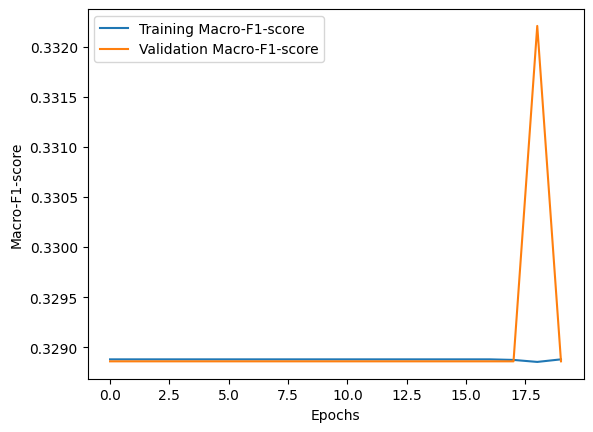

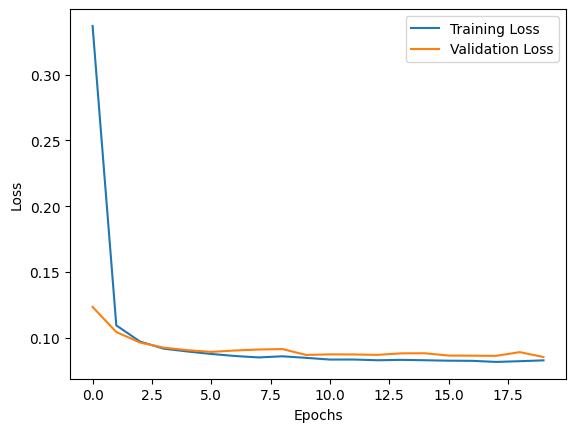

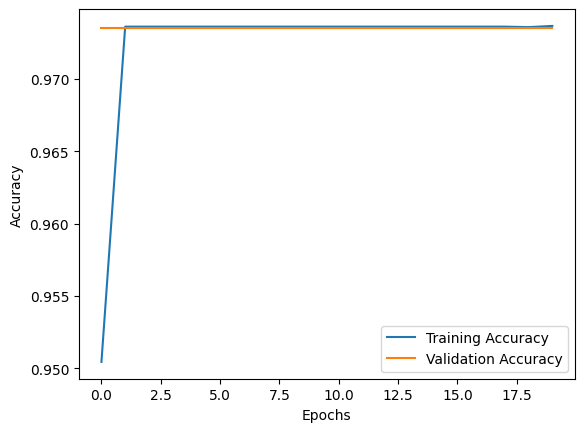

In [12]:
# Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(20):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.savefig('/task_2_Fasttext_LSTM_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/task_2_Fasttext_LSTM_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/task_2_Fasttext_LSTM_accuracy.png')  # Save accuracy figure
plt.show()


In [13]:
model.save('/task_2_Fasttext_LSTM_Dataset_2.keras')

## Validation data

In [14]:

import json

# test data
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data_val = load_data("/Dataset2-AspectTermExtraction_val.json")

texts_val = [entry["text"] for entry in data_val]
words_val = [sentence.split() for sentence in texts_val]
nested_labels_val = [entry["labels"] for entry in data_val]


In [15]:
from gensim.models import FastText
import numpy as np

fasttext_model_val = FastText(texts_val, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors_val = {}
for word in fasttext_model_val.wv.index_to_key:
    try:
        word_vectors_val[word.lower()] = fasttext_model_val.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors_val:
        return word_vectors_val[word_lower]
    else:
        return np.zeros(fasttext_model_val.vector_size)
    
word_embeddings_val = [[get_word_vector(word)  for word in sentence] for sentence in words_val]
max_wordem = max([len(sentence) for sentence in word_embeddings_val])

In [16]:
import numpy as np

max_wordem = 83  # Assuming max_wordem is defined somewhere

# Initialize a list to hold the modified sentences
modified_sentences = []

# Loop through each sentence in word_embeddings_val
for sentence in word_embeddings_val:
    sentence_length = len(sentence)
    if sentence_length < max_wordem:
        # Create a new array of zeros with the desired length
        padding = np.zeros((max_wordem - sentence_length, 100))
        # Concatenate the padding to the original sentence
        modified_sentence = np.concatenate((sentence, padding))
    else:
        # If the sentence is already longer than max_wordem, keep it as is
        modified_sentence = sentence
    # Append the modified sentence to the list
    modified_sentences.append(modified_sentence)

# Convert the list of modified sentences to a numpy array
word_embeddings_val = np.array(modified_sentences)

# Now word_embeddings_val has the desired shape
print(word_embeddings_val.shape)

(219, 83, 100)


In [17]:
labels_idx_val = [[label2idx[label] for label in sublist] for sublist in nested_labels_val]

# One-hot encode labels
# num_classes_val = len(unique_labels_val)
one_hot_labels_val = [to_categorical(sublist, num_classes=3) for sublist in labels_idx_val]

# %%
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
labels_padded_val = convert_to_list(one_hot_labels_val)

# %%
for sentence in labels_padded_val:
    sentence_length = len(sentence)
    if sentence_length < 83:
        while len(sentence) < 83:
            sentence.append([0.,1.,0.])

labels_padded_val = np.array(labels_padded_val)
labels_padded_val.shape

(219, 83, 3)

In [18]:
# %%
X_val_padded = word_embeddings_val
y_val_padded = labels_padded_val

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_val_padded, y_val_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 1s 11ms/step - loss: 0.1584 - accuracy: 0.9765
Test Loss: 0.15843889117240906
Test Accuracy: 0.9764537811279297


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_val_classes = np.argmax(y_val_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_val_classes, y_pred_classes, target_names=target_names)
print(report)

## Test Data

In [20]:

import json

# test data
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data_test = load_data("/Dataset2-AspectTermExtraction_test.json")

texts_test = [entry["text"] for entry in data_test]
words_test = [sentence.split() for sentence in texts_test]
nested_labels_test = [entry["labels"] for entry in data_test]

In [21]:
from gensim.models import FastText
import numpy as np

fasttext_model_test = FastText(texts_test, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors_test = {}
for word in fasttext_model_test.wv.index_to_key:
    try:
        word_vectors_test[word.lower()] = fasttext_model_test.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors_test:
        return word_vectors_test[word_lower]
    else:
        return np.zeros(fasttext_model_test.vector_size)
    
word_embeddings_test = [[get_word_vector(word)  for word in sentence] for sentence in words_test]
max_wordem = max([len(sentence) for sentence in word_embeddings_test])


In [22]:
import numpy as np

max_wordem = 71  # Assuming max_wordem is defined somewhere

# Initialize a list to hold the modified sentences
modified_sentences = []

# Loop through each sentence in word_embeddings_test
for sentence in word_embeddings_test:
    sentence_length = len(sentence)
    if sentence_length < max_wordem:
        # Create a new array of zeros with the desired length
        padding = np.zeros((max_wordem - sentence_length, 100))
        # Concatenate the padding to the original sentence
        modified_sentence = np.concatenate((sentence, padding))
    else:
        # If the sentence is already longer than max_wordem, keep it as is
        modified_sentence = sentence
    # Append the modified sentence to the list
    modified_sentences.append(modified_sentence)

# Convert the list of modified sentences to a numpy array
word_embeddings_test = np.array(modified_sentences)

# Now word_embeddings_test has the desired shape
print(word_embeddings_test.shape)


(328, 71, 100)


In [23]:

labels_idx_test = [[label2idx[label] for label in sublist] for sublist in nested_labels_test]

# One-hot encode labels
# num_classes_test = len(unique_labels_test)
one_hot_labels_test = [to_categorical(sublist, num_classes=3) for sublist in labels_idx_test]

In [24]:
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
labels_padded_test = convert_to_list(one_hot_labels_test)

In [25]:
for sentence in labels_padded_test:
    sentence_length = len(sentence)
    if sentence_length < 71:
        while len(sentence) < 71:
            sentence.append([0.,1.,0.])

labels_padded_test = np.array(labels_padded_test)
labels_padded_test.shape



(328, 71, 3)

In [26]:
X_test_padded = word_embeddings_test
y_test_padded = labels_padded_test

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

11/11 [==============================] - 0s 10ms/step - loss: 0.1902 - accuracy: 0.9697
Test Loss: 0.19018027186393738
Test Accuracy: 0.9696839451789856


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_test_classes, y_pred_classes, target_names=target_names)
print(report)
